In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
import numpy as np
import xarray as xr
from ftplib import FTP
import urllib
import pandas as pd
import scipy.interpolate as interp

# Real Iceberg

In [2]:
year = 2015 # 2002 through 2015 available
iip_url_base = 'ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G00807/' 
iip_filename = 'IIP_{}IcebergSeason.csv'.format(year)
iip_url = iip_url_base + iip_filename

In [3]:
r = urllib.request.urlretrieve(iip_url)
df = pd.read_csv(r[0])

In [4]:
n = df.BERG_NUMBER.mode()[0]

In [5]:
real_berg = df.loc[df['BERG_NUMBER'] == n]

In [6]:
real_berg_track = real_berg.loc[6318:6333]

# Input Fields

## Ocean (GLBv0.08)

- 3 hr
- 0.08 degree

In [7]:
glb_url = 'http://tds.hycom.org/thredds/dodsC/GLBv0.08/expt_56.3'

In [8]:
glb_ds = xr.open_dataset(glb_url, decode_times=False)

In [9]:
# June 1, 00:00 = 135120., July 1, 00:00 = 135840.
glb_ds = glb_ds.sel(depth=0.0, lat = slice(45., 51.), lon = slice(-53., -47.), time=slice(135120., 135840.))

In [10]:
water_u = glb_ds.water_u
water_v = glb_ds.water_v
water_temp = glb_ds.water_temp

In [11]:
glb_times = np.asarray(water_u.time)
glb_lats = np.asarray(water_u.lat)
glb_lons = np.asarray(water_u.lon)

In [12]:
glb_times = glb_times - 135120

#### Warning -- the box below takes a few minutes to run

In [13]:
water_u = np.asarray(water_u)
water_v = np.asarray(water_v)
water_temp = np.asarray(water_temp)

In [14]:
water_u_interp = interp.RegularGridInterpolator((glb_times, glb_lats, glb_lons), water_u)
water_v_interp = interp.RegularGridInterpolator((glb_times, glb_lats, glb_lons), water_v)
water_temp_interp = interp.RegularGridInterpolator((glb_times, glb_lats, glb_lons), water_temp)

## Atmosphere (NAVGEM)

- 6 hr
- 0.5 degree

In [21]:
navgem_url = 'http://coastwatch.pfeg.noaa.gov/erddap/griddap/erdNavgem05D10mWind_LonPM180'

In [22]:
navgem_ds = xr.open_dataset(navgem_url)

In [23]:
navgem_ds = navgem_ds.sel(time=slice('2015-06-01','2015-07-01'), latitude=slice(45,51), longitude=slice(-53,-47))

In [24]:
wind_u = navgem_ds.wnd_ucmp_height_above_ground
wind_v = navgem_ds.wnd_vcmp_height_above_ground

In [25]:
navgem_times = np.linspace(0, 120*6 - 6, 120)
navgem_lats = np.asarray(wind_u.latitude)
navgem_lons = np.asarray(wind_u.longitude)

In [26]:
wind_u = np.asarray(wind_u[:,0,:,:])
wind_v = np.asarray(wind_v[:,0,:,:])

In [27]:
wind_u_interp = interp.RegularGridInterpolator((navgem_times, navgem_lats, navgem_lons), wind_u)
wind_v_interp = interp.RegularGridInterpolator((navgem_times, navgem_lats, navgem_lons), wind_v)

# Model

In [28]:
import scipy.io as sio
import numpy.matlib
import cmath

In [29]:
# Constants
R = 6378*1e3
om = 7.2921e-5
rhow = 1027
rhoa = 1.2
rhoi = 850
drho = rhow - rhoi
Cw = 0.9
Ca = 1.3
gam = np.sqrt(rhoa*drho/rhow/rhoi*(Ca/Cw))
sst0 = -4
Cs1 = 1.5; Cs2 = 0.5; Cs3 = 0.1
CMv1 = 7.62e-3; CMv2 = 1.29e-3; CMe1 = 0.5
CMb1 = 0.58; CMb2 = 0.8; CMb3 = 0.2

In [30]:
# Timesteps
t0 = 360  # initial hour
t_inc = 1  # 3 hr
num_days = 15
tn = t_inc*num_days*24  # total number of timesteps
dt = t_inc*3600  # model timestep in seconds
tf = t0 + tn*dt  # final timestep in seconds  
t_all = np.arange(t0, t0+tn, t_inc)

In [41]:
# Iceberg Inits
x0, y0 = -50.14, 48.49   # lon, lat

# Large berg: 
    # Height: 46 metres to 75 metres above surface 
    # Length or width: 121 metres to 200 metres
    
l0 = (121 + 200)/2
w0 = (121 + 200)/2
h0 = ((46 + 75)/2)*10


timestep: 360

vau =  4.50289006958
vav =  -4.64879910737
vwu =  0.120254498954
vwv =  -0.211447684073
sst =  5.16779239501
S = 252.112810450580895
ff = 0.000109212332084
lam = 5.608740659580275
alpha = -0.244256661240217
0.953443948885
beta = 0.9534439488846986
viu = 0.179453062505700
viv = -0.315160694814071
x_new = -50.131244163987510
y_new = 48.479807688985183
Me = 2.231618098111216
Mv = 0.073829418976867
Mb = 0.351767753237082
rollover
swap l and w
l_new = 604.985343010281781
w_new = 160.403939686787993
h_new = 160.403939686787993

timestep: 361

vau =  4.50153313319
vav =  -3.74575333831
vwu =  0.137496249229
vwv =  -0.211871130118
sst =  5.16122715224
S = 398.315658703703320
ff = 0.000109195136120
lam = 3.212712517381467
alpha = -0.399606080844007
0.864934925117
beta = 0.8649349251173031
viu = 0.182427448640231
viv = -0.306331394865190
x_new = -50.122344965554291
y_new = 48.469900917926971
Me = 2.107768336391465
Mv = 0.073691913674962
Mb = 0.242473500618186
l_new = 604.89444883

viu = 0.557656537201426
viv = -0.357592656202868
x_new = -48.475130749163689
y_new = 48.179832930598209
Me = 2.635771443393002
Mv = 0.071400086781306
Mb = 0.335258013437668
l_new = 596.445198821367853
w_new = 151.863795497873809
h_new = 159.296069841556687

timestep: 431

vau =  7.35772402474
vav =  3.66820939893
vwu =  0.318604651173
vwv =  -0.348437663362
sst =  5.04436772298
S = 380.271435678382090
ff = 0.000108687488418
lam = 4.746401267765978
alpha = -0.285022511793965
0.935605841739
beta = 0.9356058417391119
viu = 0.467258500143776
viv = -0.323412576330149
x_new = -48.452470675851032
y_new = 48.169373753364809
Me = 2.561548678322420
Mv = 0.071262965033863
Mb = 0.321579017040067
l_new = 596.335498336228056
w_new = 151.754095012733956
h_new = 159.282670715846677

timestep: 432

vau =  6.86720558565
vav =  3.73383848111
vwu =  0.236344806964
vwv =  -0.319779764054
sst =  5.01348081969
S = 380.038277546985171
ff = 0.000108669734508
lam = 4.516223017909152
alpha = -0.298164065379355
0

ff = 0.000108631033248
lam = 6.960850239117957
alpha = -0.199017017314524
0.96951885186
beta = 0.969518851859677
viu = 0.476810446587533
viv = -0.297832524482506
x_new = -47.753969633053451
y_new = 48.136949553068149
Me = 3.144445454053117
Mv = 0.077520270114969
Mb = 0.444425795340115
l_new = 590.571121897632224
w_new = 145.989718574137839
h_new = 158.583731285890252

timestep: 489

vau =  11.0273073862
vav =  -4.4354257645
vwu =  0.308488847365
vwv =  -0.218303016343
sst =  5.31512894656
S = 367.735642113516064
ff = 0.000108614673100
lam = 7.100651211969813
alpha = -0.195255698536577
0.970689541091
beta = 0.9706895410912103
viu = 0.492923282166943
viv = -0.339382091611265
x_new = -47.730085015249692
y_new = 48.125973920993843
Me = 3.179989295223915
Mv = 0.076944551049808
Mb = 0.450079364375048
l_new = 590.435416320704121
w_new = 145.854012997209765
h_new = 158.564977979041288

timestep: 490

vau =  11.2018336799
vav =  -4.60373984943
vwu =  0.280084963906
vwv =  -0.242090393738
sst = 

vwv =  -0.214382991064
sst =  5.57521039302
S = 357.234972625124726
ff = 0.000107917802095
lam = 4.566595339828761
alpha = -0.295192119191412
0.930622257442
beta = 0.9306222574420578
viu = -0.091996290767030
viv = -0.220542428204300
x_new = -47.211932628188201
y_new = 47.721200545421418
Me = 2.406118908247711
Mv = 0.082580135689879
Mb = 0.312911492941737
l_new = 585.585120769849254
w_new = 141.003717446355154
h_new = 158.001680566949375

timestep: 541

vau =  -6.45189022912
vav =  -3.26243286786
vwu =  0.0302321341786
vwv =  -0.223046077691
sst =  5.60799922363
S = 357.011122424063672
ff = 0.000107905589457
lam = 4.478087138721532
alpha = -0.300451500219954
0.92795705709
beta = 0.9279570570900095
viu = -0.100383827460257
viv = -0.243460071190844
x_new = -47.216757936673972
y_new = 47.713327035792524
Me = 2.378116111992366
Mv = 0.083303009411144
Mb = 0.308696915960984
l_new = 585.482561639790788
w_new = 140.901158316296687
h_new = 157.988818195450989

timestep: 542

vau =  -5.9832035775

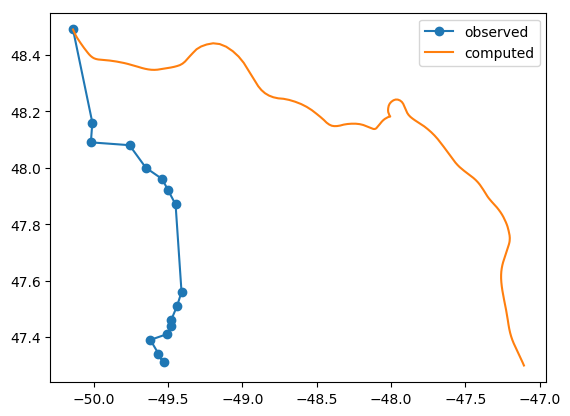

In [44]:
def main():

    x, y = x0, y0
    l, w, h = l0, w0, h0
    t = t0
    iceberg = np.array([[t0],[x0],[y0],[l0],[w0],[h0]])

    while t < max(t_all):

        x_new, y_new, l_new, w_new, h_new = iceDEF(t, x, y, l, w, h)

        
        if x_new > -47.1 or x_new < -53 or y_new > 51 or y_new < 45:
            # Iceberg out-of-bounds
            print(x_new)
            print(y_new)
            print('out-of-bounds')
            break
        

        if l_new <= 0 or w_new <= 0 or h_new <= 0:
            # Iceberg melted
            print('melted')
            break

        else:
            x, y, l, w, h = x_new, y_new, l_new, w_new, h_new
            t += t_inc
            iceberg_new = np.array([[t],[x],[y],[l],[w],[h]])
            iceberg = np.column_stack((iceberg, iceberg_new))

    plt.plot(real_berg_track['LONGITUDE'], real_berg_track['LATITUDE'], label='observed', marker='o')        
    plt.plot(iceberg[1,:],iceberg[2,:], label='computed')
    plt.legend()

        
    save_dict = {
                    't_arr': iceberg[0,:],
                    'x_arr': iceberg[1,:],
                    'y_arr': iceberg[2,:],
                    'l_arr': iceberg[3,:],
                    'w_arr': iceberg[4,:],
                    'h_arr': iceberg[5,:]
                }

    

def iceDEF(t,x,y,l,w,h):

    print('\ntimestep: {}\n'.format(t))
    

    # Extract values from input fields
    
    vau = wind_u_interp([t, y, x])[0]
    vav = wind_v_interp([t, y, x])[0]  
    vwu = water_u_interp([t, y, x])[0] 
    vwv = water_v_interp([t, y, x])[0]
    sst = water_temp_interp([t, y, x])[0]

    print('vau = ', vau)
    print('vav = ', vav)
    print('vwu = ', vwu)
    print('vwv = ', vwv)
    print('sst = ', sst)
    

    # Drifting

    S = np.pi*((l*w)/(l+w))
    ff = 2*om*np.sin((np.abs(y)*np.pi)/180)
    lam = np.sqrt(2)*Cw*(gam*np.sqrt(vau**2 + vav**2))/(ff*S)
    print('S = {0:.15f}'.format(S))
    print('ff = {0:.15f}'.format(ff))
    print('lam = {0:.15f}'.format(lam))
    
    if lam < 0.1:
        print('Taylor approx used for alpha')
        alpha = lam*(lam**4*(lam**4*(lam**4*(-0.0386699020961393*lam**4 + \
            0.055242717280199) - 0.0883883476483184) + \
            0.176776695296637) - 0.707106781186548)
    else:
        alpha = np.multiply(np.divide(np.sqrt(2),np.power(lam, 3)),(1-np.sqrt(1+np.power(lam,4))))
        
    if lam < 0.6:
        print('Taylor approx used for beta')
        beta = lam**3*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*\
            (0.0153268598203613*lam**4 - 0.0151656272365985) + \
            0.0180267866272764) + 0.0219176256311202) - \
            0.0274446790511418) + 0.0357675015202851) - \
            0.0493731785691779) + 0.0745776683282687) - \
            0.132582521472478) + 0.353553390593274)
    else:
        beta = np.real(np.multiply(np.divide(1.,np.power(lam,3.)),cmath.sqrt(np.multiply((4.+np.power(lam,4.)), \
            cmath.sqrt(1.+np.power(lam,4.)))-3.*np.power(lam,4.)-4.)))

    print('alpha = {0:.15f}'.format(alpha))
    print(beta)
    print('beta = {}'.format(beta))

    viu = vwu + gam*(-alpha*vav + beta*vau)
    viv = vwv + gam*(alpha*vau + beta*vav)

    print('viu = {0:.15f}'.format(viu))
    print('viv = {0:.15f}'.format(viv))

    y_new = y + (viv*dt)*(180/(np.pi*R))
    x_new = x + (viu*dt)/(np.cos((((y + y_new)/2)*np.pi)/180))*(180/(np.pi*R))

    print('x_new = {0:.15f}'.format(x_new))
    print('y_new = {0:.15f}'.format(y_new))
    
    
    # Melting

    Me = CMe1*(Cs1*np.sqrt(vau**2 + vav**2)**Cs2 + Cs3*np.sqrt(vau**2 + vav**2))
    Mv = CMv1*sst + CMv2*sst**2
    Mb = CMb1*np.power(np.sqrt(np.square(viu-vwu)+np.square(viv-vwv)),CMb2)*(sst - sst0)/l**CMb3

    print('Me = {0:.15f}'.format(Me))
    print('Mv = {0:.15f}'.format(Mv))
    print('Mb = {0:.15f}'.format(Mb))

    l_new = l - (Mv + Me)*(dt/(24*3600))  # convert dt from secs to days
    w_new = w - (Mv + Me)*(dt/(24*3600))
    h_new = h - Mb*(dt/(24*3600))

    if w_new < 0.85*h_new:
        # Rollover
        print('rollover')
        w_new, h_new = h_new, w_new

    if w_new > l_new:
        # Ensure l is greater than w
        print('swap l and w')
        w_new, l_new = l_new, w_new

    print('l_new = {0:.15f}'.format(l_new))
    print('w_new = {0:.15f}'.format(w_new))
    print('h_new = {0:.15f}'.format(h_new))

    return x_new, y_new, l_new, w_new, h_new    


if __name__=="__main__":
    main()